In [1]:
"""
Copyright (c) 2022 Magdalena Fuentes, Bea Steers, Luca Bondi(Robert Bosch GmbH), Julia Wilkins
All rights reserved.

This source code is licensed under the BSD-3-Clause license found in the
LICENSE file in the root directory of this source tree.
"""

%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
# from ots_embedding.eval import iou_score, eval_video
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

In [147]:
def iou_score(pred_mask, gt_bbox_coords=None, gt_box_mask=None, th=0.5, frame_size=(720, 1280), target_size=None):
    '''
    Function to compute Intersection over Union (IoU) for a given mask an bounding boxes.
    Assumes that bboxes are according to original size, and box is in format [x1, y1, x2, y2] 
    where (x1,y1) is the upper left corner and (x2,y2) the lower right corner.

    This is for one *class* currently.

    pred_mask: 
        mask thats the size of the entire image (likelihood), predictions for one frame
    gt_bbox_coords:  
        list of coordinates from ground truth [x1, y1, x2, y2] 
    gt_box_mask: 
        ground truth box mask (if passed directly instead of creating)
    th: 
        threshold tau that determines how to binarize the predicted max (which has likelihood vals)
    bbox_size: 

    target_size: 
        
    '''
    if gt_bbox_coords is None and gt_box_mask is None:
        raise ValueError("Need to pass either box or box mask")

    if len(pred_mask.shape)>2:
        pred_mask = pred_mask[...,0]
        
    # Convert the likelihood thresholds to a binary mask
    pred_mask = (pred_mask>th)**1 
    
    if target_size is None:
        target_size = frame_size

    if gt_box_mask is None:
        gt_box_mask = np.zeros(frame_size)

        # Make the overall mask
        for _box in gt_bbox_coords:
            if _box is None or sum(_box) == 0:
                continue
            # +1 is to take the "borders" into account
            # These come as [x1, y1, x2, y2]
#             curr_y = (_box[1], _box[3])
#             curr_x = (_box[0], _box[2])
            # This is because the origin is actually top left corner
#             gt_box_mask[curr_y[0]:curr_y[1] + 1, curr_x[0]:curr_x[1] + 1] = 1
            gt_box_mask = create_mask(coords=_box, existing_mask=gt_box_mask)
        
#         gt_box_mask = video_to_size(gt_box_mask, target_size)

    # We can adjust resolution if necessary
#     pred_mask = video_to_size(pred_mask, target_size)

    # Intersection, multiply and sum the 1/0s
    overlap =  np.sum(pred_mask * gt_box_mask) 

    # Union: elementwise subtraction
    # Ask about comparison again
    union = np.sum((pred_mask - gt_box_mask>0) + gt_box_mask)
    iou = overlap / union if union else 1 # This is where 1 is assigned to empty frames
    # Empty -> doesn't have GT and didn't predict anything
    return (iou, gt_box_mask, pred_mask)

In [84]:
def giou_score_current(pred_mask, gt_mask, th=0.5, frame_size=(720, 1280), target_size=None):
    '''
    Computes Generalized Intersection over Union (GIoU) score for a given predicted
    mask and ground truth mask. **NOTE** that this metric is currently only designed to
    work when there is only one bounding box in a frame.

    The score itself is IoU - (C(AUB)/C)

    pred_mask: 
        prediction mask for one frame, (not binary - it will be in likelihood)
    gt_mask_coords:  
        coordinates of ground truth bbox [x1, y1, x2, y2] 
    th: 
        threshold tau that determines how to binarize the predicted max (which has likelihood vals)
    frame_size: 
        size of the input frames (should be the same for pred/gt)
   
    target_size: 
        desired output frame size of both masks

    Returns
    -------
    (giou, gt_mask, pred_mask, c_mask): 
        iou: IoU score computed (float)
        gt_mask: reshaped ground truth box mask (2D np.ndarray, shape=target_size)
        pred_mask: reshaped prediction mask (2D np.ndarray, shape=target_size)
        c_mask: reshaped mask of smallest rectangle enclosing gt_mask and pred_mask.
        
    '''
    # Convert coordinates to mask right away
#     gt_mask = create_mask(gt_mask_coords, frame_size=frame_size)

    # If both the prediction and the ground truth are empty (all zeros)
    if not np.any(pred_mask) and not np.any(gt_mask):
        print("IoU: ", 1)
        print("GIoU: ", 1)
        return 1, pred_mask, gt_mask, create_mask([0,0,0,0], frame_size=frame_size)

    # One is empty the other is not
    if (not np.any(pred_mask) and np.any(gt_mask)) or (not np.any(gt_mask) and np.any(pred_mask)):
        return 0, pred_mask, gt_mask, create_mask([0,0,0,0], frame_size=frame_size)


    # Convert the likelihood thresholds to a binary mask
    pred_mask = (pred_mask>th)**1 
            
#     gt_mask = video_to_size(gt_mask, target_size)
#     pred_mask = video_to_size(pred_mask, target_size)

    overlap =  np.sum(pred_mask * gt_mask) 
    union = np.sum((pred_mask - gt_mask>0) + gt_mask)
    
    # Get enclosing mask
    get_c = get_enclosing_mask(gt_mask, pred_mask) # This gets (x,y) top left, width, height
    c_mask = create_mask(coords=get_c,
                         frame_size=frame_size)
    print(c_mask)
#     print((pred_mask - gt_mask>0) + gt_mask)
    c_diff = np.sum(c_mask - ((pred_mask - gt_mask>0) + gt_mask))
    
    res = np.abs(c_diff) / np.abs(np.sum(c_mask))
    
    
    iou = overlap / union
    giou = iou - res
    
#     print("Norm term: ", res)
    print("IoU: ", iou)
    print("GIoU: ", np.round(giou, 3))

    return giou, gt_mask, pred_mask, c_mask

In [3]:
def get_x1y1x2y2(mask):
    xy = list(zip(*np.where(mask == 1)))
    # If the mask is in 2d array form
    min_x = min([a[0] for a in xy])
    min_y = min([a[1] for a in xy])
    max_x = max([a[0] for a in xy])
    max_y = max([a[1] for a in xy])
    return (min_x, min_y), (max_x-min_x), (max_y-min_y)

In [4]:
def create_mask(coords, existing_mask=None, frame_size=(720, 1280)):
    # x1, y1, x2, y2 (top left corner, bottom right corner)
    if existing_mask is None:
        mask = np.zeros(frame_size)
    else:
        mask = existing_mask

    if not np.any(coords):
        return np.zeros(frame_size)
    
    curr_x = (coords[0], coords[2])
    curr_y = (coords[1], coords[3])
    mask[curr_y[0]:curr_y[1]+1, curr_x[0]:curr_x[1]+1] = 1

    return mask   

In [28]:
def get_enclosing_mask(mask1, mask2):
    # Note this assumes single instance frames :(
    # Where these are 2D arrays of the two masks

    mask1_min_xy = min(list(zip(*np.where(mask1 == 1))))
    mask1_max_xy = max(list(zip(*np.where(mask1 == 1))))

    mask2_min_xy = min(list(zip(*np.where(mask2 == 1))))
    mask2_max_xy = max(list(zip(*np.where(mask2 == 1))))

    min_x = min(mask1_min_xy[1], mask2_min_xy[1])
    min_y = min(mask1_min_xy[0], mask2_min_xy[0])

    max_x = max(mask1_max_xy[1], mask2_max_xy[1])
    max_y = max(mask1_max_xy[0], mask2_max_xy[0])


    coords = [min_x, min_y, max_x, max_y]
    return coords

In [6]:
def plot_rects(gt_mask, pred_mask, enclosing_mask=None, frame_size=(10,10)):
    
    gt_format = get_x1y1x2y2(gt_mask)
    pred_format = get_x1y1x2y2(pred_mask)
    
    fig, ax = plt.subplots()

    ax.set_xlim([0, frame_size[1]])
    ax.set_ylim([0, frame_size[0]])
    #create simple line plot
    ax.plot()
    

    #add rectangle to plot
    ax.add_patch(Rectangle(gt_format[0][::-1], gt_format[2], gt_format[1],
                           ec="gray", fc="blue", zorder=10, alpha=0.5))

    ax.add_patch(Rectangle(pred_format[0][::-1], pred_format[2], pred_format[1],
                           ec="gray", fc="red", zorder=5, alpha=0.5))
    
    if enclosing_mask is not None:
        c_format = get_x1y1x2y2(enclosing_mask)
        ax.add_patch(Rectangle(c_format[0][::-1], c_format[2], c_format[1],
                           ec="red", fc="yellow", zorder=1, alpha=0.3, linewidth=2))

    #display plot
    plt.gca().invert_yaxis()
    plt.show()

In [75]:
def plot_rects_1d(gt_mask, pred_mask, enclosing_mask=None, frame_size=(10,10)):
    
    gt_format = get_x1y1x2y2(gt_mask)
    pred_format = get_x1y1x2y2(pred_mask)
#     print(gt_format, pred_format)
    
    fig, ax = plt.subplots()

    ax.set_xlim([0, frame_size[1]])
    ax.set_ylim([0, frame_size[0]])
    #create simple line plot
    ax.plot()
    
    

    #add rectangle to plot
    ax.add_patch(Rectangle(gt_format[0][::-1], gt_format[2], 1,
                           ec="gray", fc="blue", zorder=10, alpha=0.5))

    ax.add_patch(Rectangle(pred_format[0][::-1], pred_format[2], 1,
                           ec="gray", fc="red", zorder=5, alpha=0.5))
    
    if enclosing_mask is not None:
        c_format = get_x1y1x2y2(enclosing_mask)
        ax.add_patch(Rectangle(c_format[0][::-1], c_format[2], 1,
                           ec="red", fc="yellow", zorder=1, alpha=0.3, linewidth=5))

    #display plot
    plt.gca().invert_yaxis()
    plt.show()

In [9]:
def giou_score(pred_mask, gt_mask, frame_size=(720, 1280)):
    
    # If both the prediction and the ground truth are empty (all zeros)
    if not np.any(pred_mask) and not np.any(gt_mask):
        print("IoU: ", 1)
        print("GIoU: ", 1)
        return 1, pred_mask, gt_mask, create_mask([0,0,0,0], frame_size)
    
    overlap =  np.sum(pred_mask * gt_mask) 
    union = np.sum((pred_mask - gt_mask>0) + gt_mask)
    
    # Get enclosing mask
    get_c = get_enclosing_mask(gt_mask, pred_mask) # This gets (x,y) top left, width, height
    c_mask = create_mask(coords=get_c,
                         frame_size=frame_size)
    c_diff = np.sum(c_mask - ((pred_mask - gt_mask>0) + gt_mask))
    res = np.abs(c_diff) / np.abs(np.sum(c_mask))
    
    iou = overlap / union
    giou = iou - res
    
    print("Norm term: ", res)
    print("IoU: ", iou)
    print("GIoU: ", giou)

    return giou, gt_mask, pred_mask, c_mask

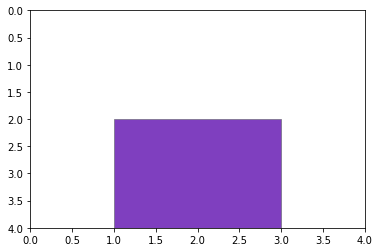

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]] [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]]


In [99]:
mask_size = (5,5)
mask = np.zeros(mask_size)
mask[2:4+1, 1:3+1] = 1
box = [1, 2, 3, 4]
score, gt_mask, pred_mask = iou_score(mask, [box], frame_size=mask_size)

plot_rects(gt_mask, pred_mask, #enclosing_mask=c_mask,
           frame_size=(mask_size[0]-1, mask_size[1]-1))
print(gt_mask, pred_mask)

creating box mask
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]]
Norm term:  0.0
IoU:  1.0
GIoU:  1.0


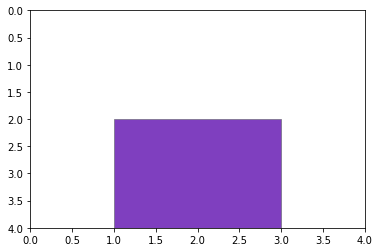

In [57]:
mask_size = (5,5)
mask = np.zeros(mask_size)
mask[2:4+1, 1:3+1] = 1
box = [1, 2, 3, 4]
score, gt_mask, pred_mask = iou_score(mask, [box], frame_size=mask_size)
# assert score[0] == 1

# Get GIOU
get_c = get_enclosing_mask(gt_mask, pred_mask) # This gets (x,y) top left, width, height
c_mask = create_mask(coords=get_c,
                     frame_size=(5,5))
r = giou_score_current(gt_mask, pred_mask, frame_size=(5,5))
plot_rects(gt_mask, pred_mask, #enclosing_mask=c_mask,
           frame_size=(mask_size[0]-1, mask_size[1]-1))

creating box mask
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Norm term:  0.0
IoU:  0.2682926829268293
GIoU:  0.2682926829268293


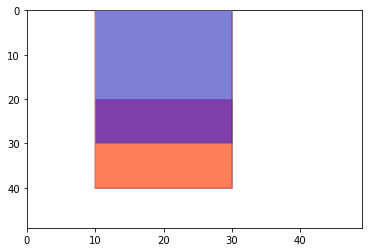

In [58]:
mask_size = (50,50)
mask = np.zeros(mask_size)
mask[20:40+1, 10:30+1] = 1
box = [10, 0, 30, 30]
score, g, p = iou_score(mask, [box],frame_size=mask_size)

r = giou_score_current(g,p, th=0.5, frame_size=(50,50))
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))

creating box mask
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Norm term:  0.0
IoU:  0.0
GIoU:  0.0


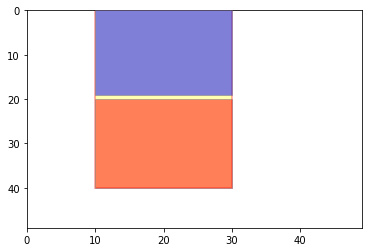

In [59]:
mask_size = (50,50)
mask = np.zeros(mask_size)
mask[20:40+1, 10:30+1] = 1
box = [10, 0, 30, 19]
score, g, p = iou_score(mask, [box],frame_size=mask_size)

r = giou_score_current(g,p, frame_size=(50,50))
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))

creating box mask


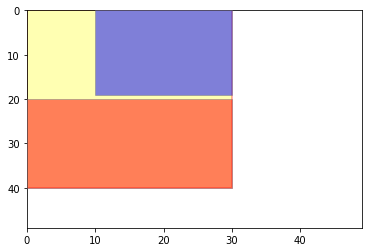

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
mask_size = (50,50)
mask = np.zeros(mask_size)
mask[20:40+1, 0:30+1] = 1
box = [10, 0, 30, 19]
score, g, p = iou_score(mask, [box],frame_size=mask_size)

r = giou_score_current(g,p, frame_size=(50,50))
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))
print(r[1])

creating box mask


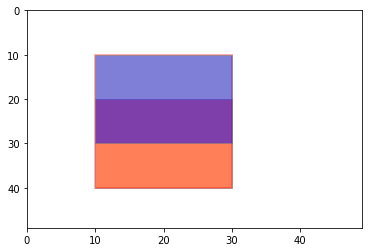

0.3548387096774194


In [19]:
mask_size = (50,50)
mask = np.zeros(mask_size)
mask[20:40+1, 10:30+1] = 1
box = [10, 10, 30, 30]
score, g, p = iou_score(mask, [box],frame_size=mask_size)

r = giou_score_current(g,p, frame_size=(50,50))
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))
print(r[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
IoU:  0.29732868757259
GIoU:  0.193


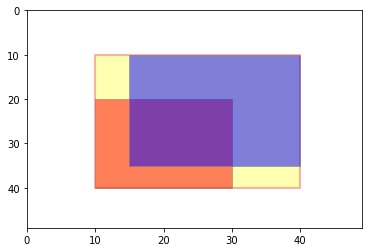

In [96]:
mask_size = (50,50)
mask = np.zeros(mask_size)
mask[20:40+1, 10:30+1] = 1
box = [15, 10, 40, 35]
score, g, p = iou_score(mask, [box],frame_size=mask_size)

r = giou_score_current(g,p, frame_size=(50,50))
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))

[[1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]]
IoU:  0.0
GIoU:  -0.25


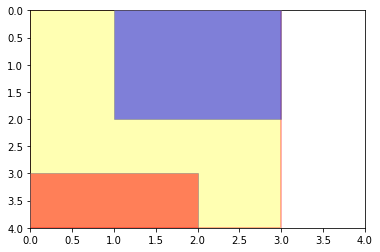

In [91]:
mask_size = (5, 5)
mask = np.zeros(mask_size)
mask[3:5, 0:3] = 1
box = [1, 0, 3, 2]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score_current(g,p, frame_size=mask_size)
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))

creating box mask
Norm term:  0.125
IoU:  0.0
GIoU:  -0.125


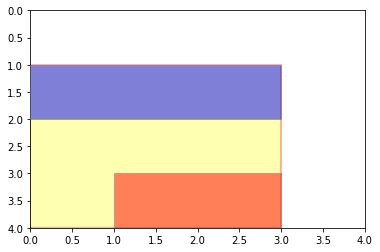

In [18]:
mask_size = (5, 5)
mask = np.zeros(mask_size)
mask[3:5, 1:4] = 1
box = [0, 1, 3, 2]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))

creating box mask
Norm term:  0.25
IoU:  0.0
GIoU:  -0.25


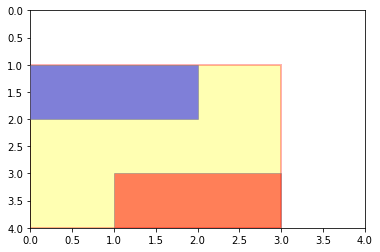

In [19]:
mask_size = (5, 5)
mask = np.zeros(mask_size)
mask[3:5, 1:4] = 1
box = [0, 1, 2, 2]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects(g,p, enclosing_mask=r[3],
           frame_size=(mask_size[0]-1, mask_size[1]-1))

## 1D Tests

Tests: 
- Overlapping, same size
- One box contains other box
- Overlapping, different size
- Both boxes empty (empty frames -> 1)
- OPEN QUESTIONL: one box empty, other box not empty
- Closer vs farther away non-overlapping
- Boxes exactly next to eachother

creating box mask
Norm term:  0.0
IoU:  1.0
GIoU:  1.0
((0, 1), 0, 1) ((0, 1), 0, 1)


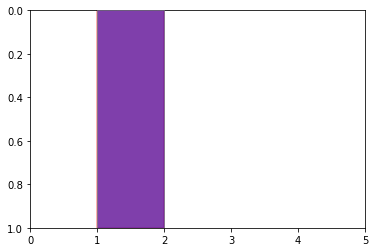

In [14]:
# Overlapping perfect score
mask_size = (1, 5)
mask = np.zeros(mask_size)
mask[0:1, 1:3] = 1
box = [1, 0, 2, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

In [12]:
g, p, r[3]

(array([[0., 1., 1., 0., 0.]]),
 array([[0, 1, 1, 0, 0]]),
 array([[0., 1., 1., 0., 0.]]))

[[1. 1. 1. 1. 1. 1.]]
IoU:  0.0
GIoU:  -0.333


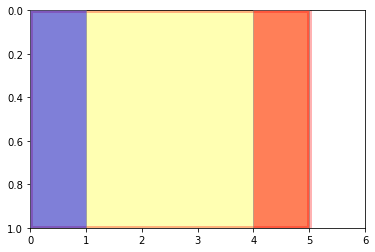

In [85]:
# Non-overlapping, farther-away
mask_size = (1, 6)
mask = np.zeros(mask_size)
mask[0:2, 4:6] = 1
box = [0, 0, 1, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score_current(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

[[1. 1. 1. 1. 1. 0.]]
IoU:  0.0
GIoU:  -0.2


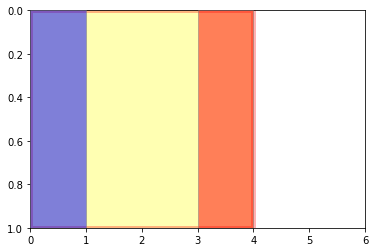

In [86]:
# Non-overlapping, closer
mask_size = (1, 6)
mask = np.zeros(mask_size)
mask[0:2, 3:5] = 1
box = [0, 0, 1, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score_current(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

In [146]:
gt_bbox_coords = [[0, 0, 1, 1], [0,0,2,2], [0,0,3,3]]
frame_size=(1,6)
gt_box_mask = np.zeros(frame_size)

# Make the overall mask
for _box in gt_bbox_coords:
    if _box is None or sum(_box) == 0:
        continue

#     curr_y = (_box[1], _box[3])
#     curr_x = (_box[0], _box[2])
#     print(curr_y, curr_x)
#     # This is because the origin is actually top left corner
#     print(gt_box_mask)
#     gt_box_mask[curr_y[0]:curr_y[1] + 1, curr_x[0]:curr_x[1] + 1] = 1
    gt_box_mask = create_mask(coords=_box, existing_mask=gt_box_mask)
print(gt_box_mask)

[[1. 1. 1. 1. 0. 0.]]


In [120]:
gt_box_mask

array([[1., 1., 0., 0., 0., 0.]])

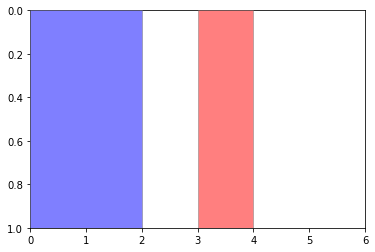

[[1. 1. 1. 0. 0. 0.]] [[0 0 0 1 1 0]]


In [150]:
# Non-overlapping, closer
mask_size = (1, 6)
mask = np.zeros(mask_size)
mask[0:2, 3:5] = 1
box = [[0, 0, 1, 1], [0,0,2,1]]
score, g, p = iou_score(pred_mask=mask, gt_bbox_coords=box, gt_box_mask=None, frame_size=mask_size)
# r = giou_score_current(g,p, frame_size=mask_size)
plot_rects_1d(g,p,
           frame_size=mask_size)
print(g,p)

In [110]:
print(g, p)

[[1. 1. 0. 0. 0. 0.]] [[0 0 0 1 1 0]]


creating box mask
Norm term:  0.0
IoU:  0.0
GIoU:  0.0
((0, 0), 0, 1) ((0, 2), 0, 1)


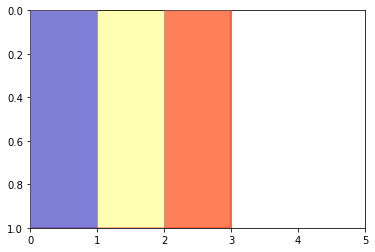

In [16]:
# Exactly touching (non-overlapping)
# Note: this plot is a bit misleading-look at the masks
# But the score is being calculated correctly
mask_size = (1, 5)
mask = np.zeros(mask_size)
mask[0:2, 2:4] = 1
box = [0, 0, 1, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

In [148]:
g, p, r[3]

(array([[1., 1., 0., 0., 0.]]),
 array([[0, 0, 1, 1, 0]]),
 array([[1., 1., 1., 1., 0.]]))

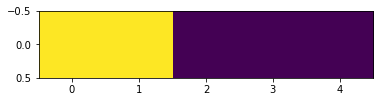

In [150]:
plt.imshow(g)

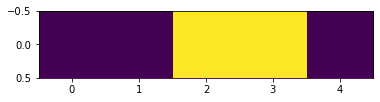

In [151]:
plt.imshow(p)

creating box mask
Norm term:  0.0
IoU:  0.3333333333333333
GIoU:  0.3333333333333333
((0, 0), 0, 1) ((0, 1), 0, 1)


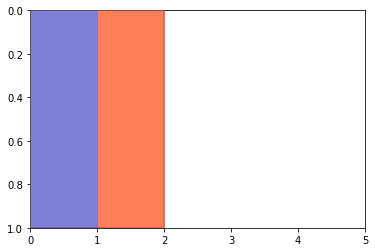

In [17]:
# Small overlap (visually this is also strange, but scores make sense)
mask_size = (1, 5)
mask = np.zeros(mask_size)
mask[0:2, 1:3] = 1
box = [0, 0, 1, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

In [156]:
g, p, r[3]

(array([[1., 1., 0., 0., 0.]]),
 array([[0, 1, 1, 0, 0]]),
 array([[1., 1., 1., 0., 0.]]))

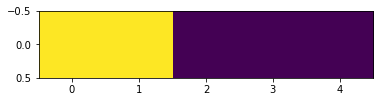

In [157]:
plt.imshow(g)

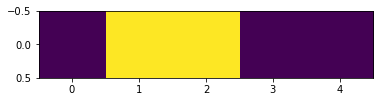

In [158]:
plt.imshow(p)

creating box mask
Norm term:  0.0
IoU:  0.6666666666666666
GIoU:  0.6666666666666666
((0, 0), 0, 2) ((0, 1), 0, 1)


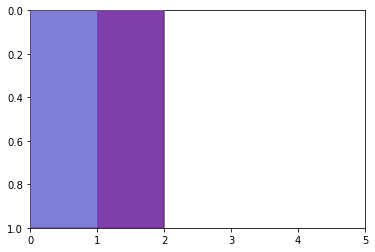

In [18]:
# Overlapping, different sizes
mask_size = (1, 5)
mask = np.zeros(mask_size)
mask[0:1, 1:3] = 1
box = [0, 0, 2, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

creating box mask
Norm term:  0.0
IoU:  0.4
GIoU:  0.4
((0, 0), 0, 4) ((0, 1), 0, 1)


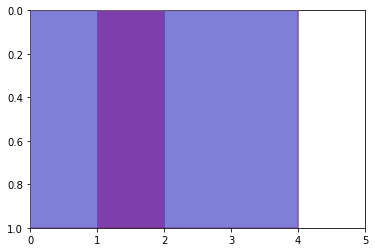

In [19]:
# One box contains the other box
mask_size = (1, 5)
mask = np.zeros(mask_size)
mask[0:1, 1:3] = 1
box = [0, 0, 4, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

creating box mask
Norm term:  0.0
IoU:  0.4
GIoU:  0.4
((0, 0), 0, 1) ((0, 0), 0, 4)


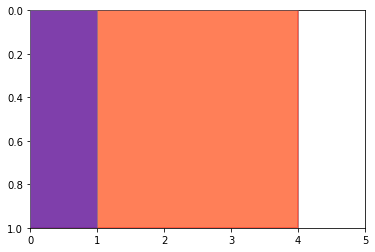

In [20]:
# One box contains other box, flipped
mask_size = (1, 5)
mask = np.zeros(mask_size)
mask[0:1, 0:5] = 1
box = [0, 0, 1, 1]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)
plot_rects_1d(g,p, enclosing_mask=r[3],
           frame_size=mask_size)

In [238]:
# Either box is none
mask_size = (1, 5)
mask = np.zeros(mask_size)
box = [0, 0, 0, 0]
score, g, p = iou_score(mask, [box],frame_size=mask_size)
r = giou_score(g,p, frame_size=mask_size)

creating box mask
IoU:  1
GIoU:  1


In [239]:
p

array([[0, 0, 0, 0, 0]])

In [240]:
p

array([[0, 0, 0, 0, 0]])

## Test with real video annotations!

In [243]:
import pandas as pd
from collections import Counter

In [244]:
vid_ann = pd.read_csv('../../urbansas_dataset/video_annotations.csv')

In [247]:
fname_set = list(set(vid_ann['filename']))
len(fname_set)

980

In [271]:
# for f in fname_set:
def get_count_x_frame_ids(vid_annotations, filename, num_instances=1):
    # Get the frame_ids of a file with X annotations in that frame
    dic = {}
    curr_vid_annots = vid_annotations[(vid_annotations.filename == filename)]
    frame_ids = list(curr_vid_annots['frame_id'])
    count_frame_d = dict(Counter(frame_ids))
    dic[filename] = []
    for frame, count in count_frame_d.items():
        if count == num_instances:
            dic[filename].append(frame)
    return dic

In [274]:
get_count_x_frame_ids(vid_ann, 'rivera0923_01_5', 1)

{'rivera0923_01_5': [2, 3, 4, 5, 11, 12, 13, 14, 15, 20]}

In [276]:
single_sample = []
for f in fname_set[:5]:
    single_sample.append(get_count_x_frame_ids(vid_ann, f, 1))

In [277]:
single_sample

[{'rivera0923_01_5': [2, 3, 4, 5, 11, 12, 13, 14, 15, 20]},
 {'street_traffic-barcelona-163-4976': []},
 {'street_traffic-vienna-176-5421': [15, 16, 17, 18, 19, 20, 21]},
 {'templete0103_02_16': [1, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16]},
 {'rivera0923_00_11': [1, 2, 8]}]

In [278]:
# Now filter the original dataframe to get the single frame coordinates

In [350]:
# Test with one
sing = vid_ann[(vid_ann["filename"]=="rivera0923_01_5") & (vid_ann["frame_id"]==2)].iloc[0]
gt_coords = np.array([sing.x, sing.y, sing.x + sing.w, sing.y + sing.h]).astype(int)
print(gt_coords)
fake_pred_coords = [600, 200, 700, 230]

[500 452 595 525]


Norm term:  0.8438024600921772
IoU:  0.0
GIoU:  -0.8438024600921772


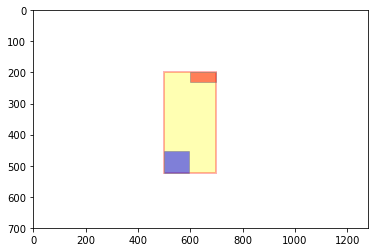

In [351]:
s, g, p, r = giou_score(create_mask(gt_coords, frame_size=(720, 1280)), 
           create_mask(fake_pred_coords, frame_size=(720, 1280)),
          frame_size=(720,1280))

plot_rects(create_mask(gt_coords, frame_size=(720, 1280)), 
           create_mask(fake_pred_coords, frame_size=(720, 1280)),
           r,
          frame_size=(700, 1280))

In [360]:
# Test with a closer one
sing = vid_ann[(vid_ann["filename"]=="rivera0923_01_5") & (vid_ann["frame_id"]==2)].iloc[0]
gt_coords = np.array([sing.x, sing.y, sing.x + sing.w, sing.y + sing.h]).astype(int)
print(gt_coords)
fake_pred_coords = [500, 300, 600, 330]

[500 452 595 525]


Norm term:  0.5516078156488216
IoU:  0.0
GIoU:  -0.5516078156488216


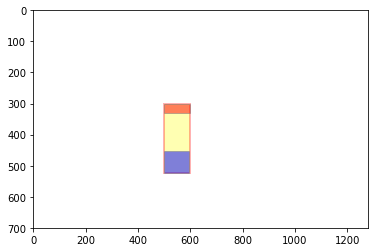

In [366]:
s, g, p, r = giou_score2(create_mask(gt_coords, frame_size=(720, 1280)), 
           fake_pred_coords,
          frame_size=(720,1280))

plot_rects(create_mask(gt_coords, frame_size=(720, 1280)), 
           create_mask(fake_pred_coords, frame_size=(720, 1280)),
           r,
          frame_size=(700, 1280))

## [OLD] Unidimensional mask, do they work?

In [ ]:
mask_size = (1,50)
mask = np.zeros(mask_size)
box = [20, 0, 40, 1]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 0, score  # this is a hard one, if the mask is empty but the gth is not the score is 0!
box = [0,0,0,0]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 1, score 
mask[:,20:40] = 1
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 0, score  # this is a hard one, if the box is empty but the mask is not the score is 0!
box = [20, 0, 40, 1]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 1, score
box = [10, 0, 20, 1]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 0, score
box = [0, 0, 30, 1]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 0.25, score
box = [10, 0, 30, 1]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 1/3, score
box = [0, 0, 40, 1]
score = iou_score(mask, [box], bbox_size=mask_size)
assert score[0] == 0.5, score

In [ ]:
35*0.25

In [ ]:
score[1].shape

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(score[1])

In [ ]:
score

In [ ]:
import scipy

def dialations(mask, n=None):
    mask = np.asarray(mask)
    yield mask
    for i in range(n or mask.shape[-1]):
        mask = (scipy.signal.convolve2d(mask, [[1, 1, 1]], mode='same', boundary='symm') > 0).astype(float)
        yield mask

def iou_dialate(pred, gt, n=None):
    pred = np.asarray(pred)
    ious = []
    for mask in dialations(gt, n):
        ious.append(iou_score(mask, pred, bbox_size=mask.shape)[0])
    return ious

In [ ]:
mask = np.zeros((1, 15))
mask[:,6:8] = 1
mask[:,10:12] = 1
box = [[0, 0, 14, 0]]
ious = iou_dialate(box, mask)
plt.plot(ious)
plt.ylim([0, None])
plt.show()
# box = [20, 0, 40, 1]
for i, (iou, m) in enumerate(zip(ious, dialations(mask))):
#     print(m)
    plt.title(f'dialation={i} iou={iou}')
    plt.imshow(m, vmin=0, vmax=1)
    for b in box:
        plt.plot([b[0], b[2]], [0,0])
    plt.show()
plt.close()

In [ ]:
mask = np.zeros((1, 15))
mask[:,6:8] = 1
# mask[:,10:12] = 1
box = [[3, 0, 5, 0]]
ious = iou_dialate(box, mask)
plt.plot(ious)
plt.ylim([0, None])
plt.show()
# box = [20, 0, 40, 1]
for i, (iou, m) in enumerate(zip(ious, dialations(mask))):
#     print(m)
    plt.title(f'dialation={i} iou={iou}')
    plt.imshow(m, vmin=0, vmax=1)
    for b in box:
        plt.plot([b[0], b[2]], [0,0])
    plt.show()
plt.close()

In [ ]:
mask = np.zeros((1, 15))
mask[:,6:8] = 1
mask[:,10:12] = 1
box = [[3, 0, 5, 0], [10, 0, 11, 0]]
ious = iou_dialate(box, mask)
plt.plot(ious)
plt.ylim([0, None])
plt.show()
# box = [20, 0, 40, 1]
for i, (iou, m) in enumerate(zip(ious, dialations(mask))):
#     print(m)
    plt.title(f'dialation={i} iou={iou}')
    plt.imshow(m, vmin=0, vmax=1)
    for b in box:
        plt.plot([b[0], b[2]], [0,0])
    plt.show()
plt.close()